# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões (2022)

Autor: Pedro H. G. Cazelatto

## Bibliotecas

Importando as bibliotecas necessárias para a execução do código.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

## Dados

Importando os dados necessários para o treino e teste.

In [2]:
trainData = pd.read_csv(
    "../input/adult-pmr3508/train_data.csv",
    na_values= '?',
    index_col= ['Id'],
    header= 0,
    names= [
        "Id",
        "Age",
        "Workclass",
        "Fnlwgt",
        "Education",
        "Education-num",
        "Marital-status",
        "Occupation",
        "Relationship",
        "Race",
        "Sex",
        "Capital-gain",
        "Capital-loss",
        "Hours-per-week",
        "Native-country",
        "Target"
    ]
)

testData = pd.read_csv(
    "../input/adult-pmr3508/test_data.csv",
    na_values= '?',
    index_col= ['Id'],
    header= 0,
    names= [
        "Id",
        "Age",
        "Workclass",
        "Fnlwgt",
        "Education",
        "Education-num",
        "Marital-status",
        "Occupation",
        "Relationship",
        "Race",
        "Sex",
        "Capital-gain",
        "Capital-loss",
        "Hours-per-week",
        "Native-country"
    ]
)

## Análise dos Dados

Antes de conseguir treinar alguma coisa, é necessário analisar os dados disponíveis e tratá-los.

Primeiro analisarei os dados categóricos e converterei-os em numéricos, através de One Hot Encoding ou Binary Encoding, a depender do dado.

In [3]:
trainData.describe(include= ['O'])

,Workclass,Education,Marital-status,Occupation,Relationship,Race,Sex,Native-country,Target
count,30724,32560,32560,30717,32560,32560,32560,31977,32560
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


In [4]:
testData.describe(include= ['O'])

,Workclass,Education,Marital-status,Occupation,Relationship,Race,Sex,Native-country
count,15317,16280,16280,15314,16280,16280,16280,16006
unique,8,16,7,14,6,5,2,40
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,11209,5283,7403,2032,6523,13946,10859,14661


A princípio, a coluna **Education** pode ser removida, pois já há uma correspondente numérica, a **Education-num**.

In [5]:
trainData.drop("Education", axis= 1, inplace= True)

As colunas **Workclass**, **Occupation** e **Native-country** possuem dados faltantes, então começarei por elas.

Para as outras colunas, vamos analisar caso a caso.

### Workclass

Faltam 1836 dados na coluna Workclass


<AxesSubplot: >

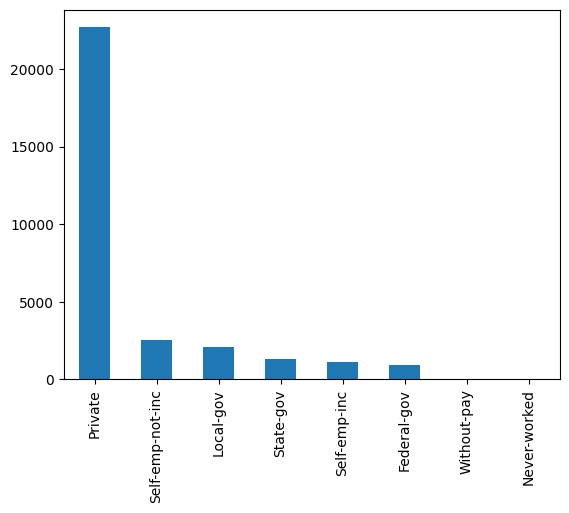

In [6]:
print("Faltam " + str(trainData["Workclass"].isnull().sum()) + " dados na coluna Workclass")
trainData["Workclass"].value_counts().plot(kind= "bar")

Como esta categoria possui a maioria de seus rótulos como *Private*, classificar os dados faltantes com a moda é uma boa estratégia.

In [7]:
trainData["Workclass"].fillna("Private", inplace= True)

Com a grande discrepância entre *Private* e os outros rótulos, farei tal agrupamento de maneira numérica trocando a coluna para **isPrivate**, colocando 0 em outras classes de trabalho.

In [8]:
trainData.loc[trainData["Workclass"] != "Private", "Workclass"] = 0
trainData.loc[trainData["Workclass"] == "Private", "Workclass"] = 1
trainData["Workclass"] = trainData["Workclass"].astype(float)
trainData.rename(columns= {"Workclass": "isPrivate"}, inplace= True)

### Occupation

Faltam 1843 dados na coluna Occupation


<AxesSubplot: >

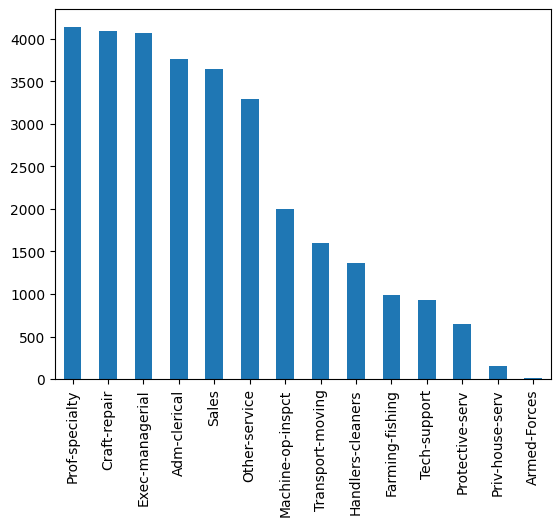

In [9]:
print("Faltam " + str(trainData["Occupation"].isnull().sum()) + " dados na coluna Occupation")
trainData["Occupation"].value_counts().plot(kind= "bar")

Na categoria **Occupation**, não é possível utilizar a moda, pois os três valores mais frequentes estão muito próximos. A princípio irei excluir os dados faltantes e reclassificarei os dados usando One Hot Encoding.

In [10]:
trainData["Occupation"].dropna(inplace= True)

In [11]:
trainData = pd.concat([trainData, pd.get_dummies(trainData["Occupation"], prefix= "Occ")], axis= 1)
trainData.drop("Occupation", axis= 1, inplace= True)

### Native-country

Faltam 583 dados na coluna Native-country


<AxesSubplot: >

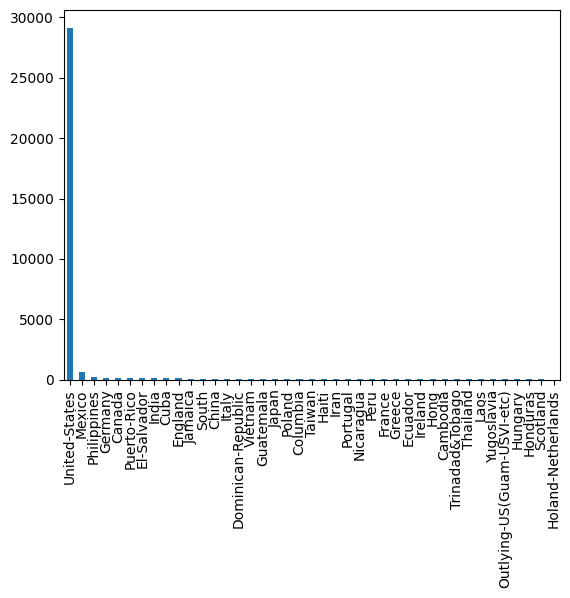

In [12]:
print("Faltam " + str(trainData["Native-country"].isnull().sum()) + " dados na coluna Native-country")
trainData["Native-country"].value_counts().plot(kind= "bar")

O primeiro ponto com a coluna **Native-country** será unificar os dados diferentes de *United-States*, pois tem quantidades muito pequenas, e transformar a coluna em binária **isFromUS**.

Levando em conta a forte cultura patriótica estadunidense, penso que aqueles que se recusaram a responder a nacionalidade no censo provavelmente são imigrantes, portanto completarei os dados com 0.

In [13]:
trainData.loc[trainData["Native-country"] != "United-States", "Native-country"] = 0
trainData.loc[trainData["Native-country"] == "United-States", "Native-country"] = 1
trainData["Native-country"] = trainData["Native-country"].astype(float)
trainData.rename(columns={"Native-country": "isFromUS"}, inplace= True)

### Marital-status, Relationship & Race

<AxesSubplot: title={'center': 'Race'}>

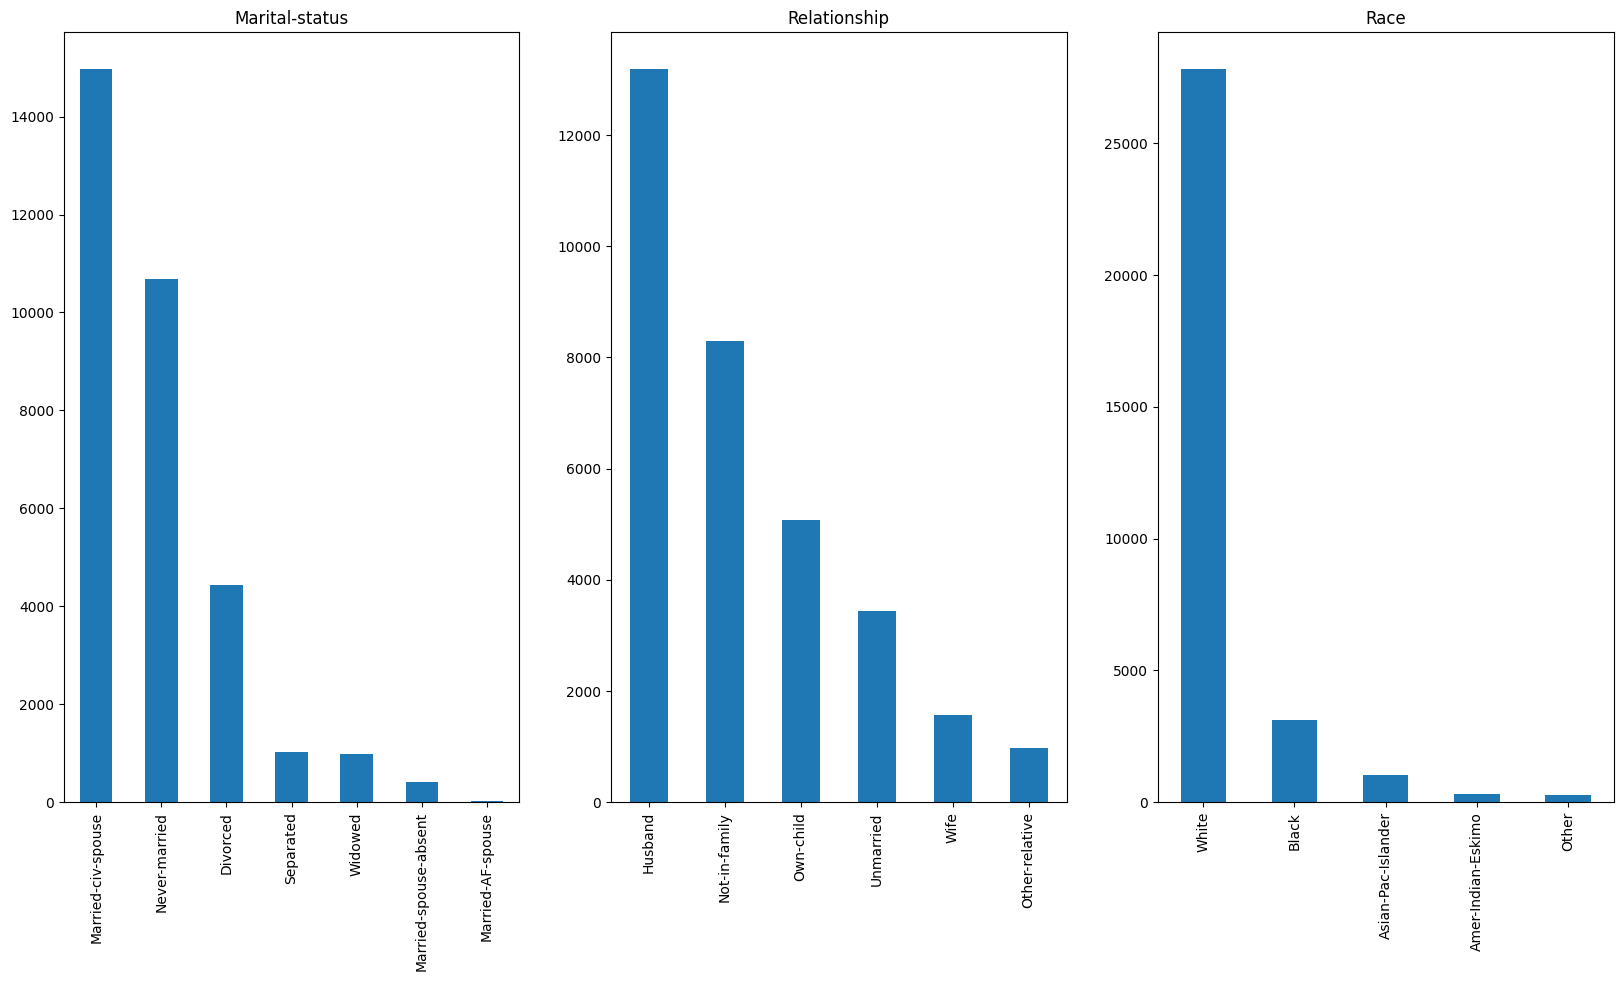

In [14]:
fig, axis = plt.subplots(nrows= 1, ncols= 3)
trainData["Marital-status"].value_counts().plot(kind= "bar", ax= axis[0], title= "Marital-status", figsize=(20,10))
trainData["Relationship"].value_counts().plot(kind= "bar", ax= axis[1], title= "Relationship")
trainData["Race"].value_counts().plot(kind= "bar", ax= axis[2], title= "Race")

Irei apenas recodificá-las com One Hot Encoding

In [15]:
trainData = pd.concat([trainData, pd.get_dummies(trainData["Marital-status"], prefix= "Mar")], axis= 1)
trainData = pd.concat([trainData, pd.get_dummies(trainData["Relationship"], prefix= "Rel")], axis= 1)
trainData = pd.concat([trainData, pd.get_dummies(trainData["Race"], prefix= "Race")], axis= 1)
trainData.drop("Marital-status", axis= 1, inplace= True)
trainData.drop("Relationship", axis= 1, inplace= True)
trainData.drop("Race", axis= 1, inplace= True)

### Sex & Target

Tais categorias possuem apenas dois valores únicos, então tornarei suas variáveis binárias.

In [16]:
trainData.loc[trainData["Sex"] != "Male", "Sex"] = 0.0
trainData.loc[trainData["Sex"] == "Male", "Sex"] = 1.0
trainData["Sex"] = trainData["Sex"].astype(float)
trainData.rename(columns={"Sex": "isMale"}, inplace= True)
trainData.loc[trainData["Target"] != ">50K", "Target"] = 0
trainData.loc[trainData["Target"] == ">50K", "Target"] = 1
trainData["Target"] = trainData["Target"].astype(float)

### Correlação entre os dados

Calculo então a correlação absoluta entre os dados e a categoria **Target**, de modo a filtrar os dados relevantes.

<AxesSubplot: >

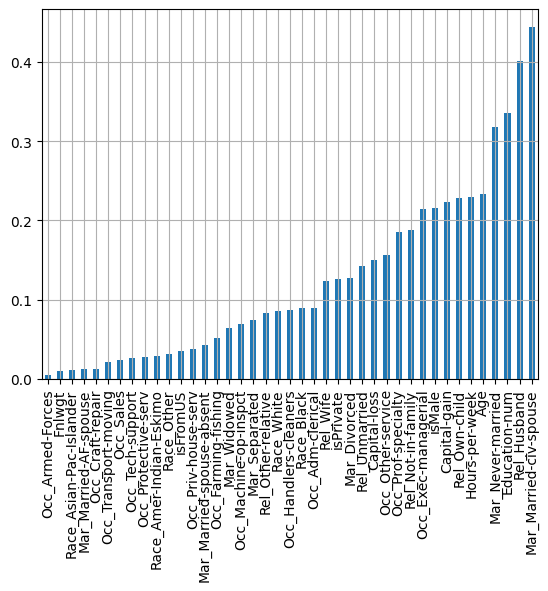

In [17]:
correlation = trainData.corr()
correlation.drop("Target", axis = 0, inplace= True)
correlation["Target"].abs().sort_values().plot(kind= "bar", grid= True)

## Treinamento do Classificador kNN

Para treinar o classificador, é preciso antes definir alguns hiperparâmetros, como o número de vizinhos (*k*) e quantidade de pastas para a verificação cruzada (*cvFolds*).

O número de pastas fixarei em 10, um valor razoável para obter uma boa média de acurácia.

O número de vizinhos será variado de 1 até 30.

Em minha análise, modificarei também a variável *minCorr*, de modo a descartar as categorias com correlação muito baixa. Usarei os valores dos quartis: [0.031832, 0.087269, 0.188477].

In [18]:
correlation["Target"].abs().sort_values().describe()

count    41.000000
mean      0.123524
std       0.111602
min       0.005044
25%       0.031832
50%       0.087269
75%       0.188477
max       0.444688
Name: Target, dtype: float64

In [19]:
cvFolds = 10
maxK = 30
possibleCorr = [0.031832, 0.087269, 0.188477]

In [20]:
results = list()
for idx, minCorr in enumerate(possibleCorr):
    results.append(list())
    print("minCorr = " + str(minCorr))
    bestScore = 0
    bestK = 0
    trainDataX = trainData.drop("Target", axis= 1)
    trainDataY = trainData["Target"]
    indices = correlation["Target"].where(correlation["Target"].abs() <= minCorr).dropna().index
    trainDataX.drop(indices, axis= 1, inplace= True)
    print("\tProcurando melhor K: ", end= '')
    for k in range(1, maxK+1):
        knn = KNeighborsClassifier(n_neighbors= k, p= 1)
        valScore = cross_val_score(knn, trainDataX, trainDataY, cv= cvFolds)
        print("*", end= '')
        results[idx].append(valScore.mean())
        if valScore.mean() > bestScore:
            bestScore = valScore.mean()
            bestK = k
    print("\n\tBest K = " + str(bestK) +", with score = {}".format(round(bestScore*100, 4)))

minCorr = 0.031832
	Procurando melhor K: ******************************
	Best K = 18, with score = 85.8538
minCorr = 0.087269
	Procurando melhor K: ******************************
	Best K = 17, with score = 85.8354
minCorr = 0.188477
	Procurando melhor K: ******************************
	Best K = 29, with score = 84.7082


In [21]:
bestK = 0
bestCorr = 0
bestScore = 0
for i in range(len(results)):
    for j in range(len(results[i])):
        if bestScore < results[i][j]:
            bestScore = results[i][j]
            bestCorr = possibleCorr[i]
            bestK = j+1
            
print("Melhor corte: " + str(bestCorr) + " com K = " + str(bestK))

Melhor corte: 0.031832 com K = 18


## Classificação dos Dados de Teste

Encontrados os valores de *k* e *minCorr*, basta construir o classificador, mas antes é importante tratar os dados de teste da mesma maneira que tratei os dados de treino.

In [22]:
testData.drop("Education", axis= 1, inplace= True)
testData["Workclass"].fillna("Private", inplace= True)
testData.loc[testData["Workclass"] != "Private", "Workclass"] = 0
testData.loc[testData["Workclass"] == "Private", "Workclass"] = 1
testData["Workclass"] = testData["Workclass"].astype(float)
testData.rename(columns= {"Workclass": "isPrivate"}, inplace= True)
testData["Occupation"].dropna(inplace= True)
testData = pd.concat([testData, pd.get_dummies(testData["Occupation"], prefix= "Occ")], axis= 1)
testData.drop("Occupation", axis= 1, inplace= True)
testData.loc[testData["Native-country"] != "United-States", "Native-country"] = 0
testData.loc[testData["Native-country"] == "United-States", "Native-country"] = 1
testData["Native-country"] = testData["Native-country"].astype(float)
testData.rename(columns= {"Native-country": "isFromUS"}, inplace= True)
testData = pd.concat([testData, pd.get_dummies(testData["Marital-status"], prefix= "Mar")], axis= 1)
testData = pd.concat([testData, pd.get_dummies(testData["Relationship"], prefix= "Rel")], axis= 1)
testData = pd.concat([testData, pd.get_dummies(testData["Race"], prefix= "Race")], axis= 1)
testData.drop("Marital-status", axis= 1, inplace= True)
testData.drop("Relationship", axis= 1, inplace= True)
testData.drop("Race", axis= 1, inplace= True)
testData.loc[testData["Sex"] != "Male", "Sex"] = 0
testData.loc[testData["Sex"] == "Male", "Sex"] = 1
testData["Sex"] = testData["Sex"].astype(float)
testData.rename(columns= {"Sex": "isMale"}, inplace= True)

### Construindo o Classificador

In [23]:
toRemove = correlation["Target"].where(correlation["Target"].abs() <= bestCorr).dropna().index

In [24]:
trainY = trainData["Target"]
trainX = trainData.drop("Target", axis= 1)
trainX.drop(toRemove, axis= 1, inplace= True)
testData.drop(toRemove, axis= 1, inplace= True)

In [25]:
kNearNeighbor = KNeighborsClassifier(n_neighbors= bestK, p= 1)
kNearNeighbor.fit(trainX, trainY)

KNeighborsClassifier(n_neighbors=18, p=1)

In [30]:
guess = kNearNeighbor.predict(testData)
submission = pd.DataFrame()
submission[0] = testData.index
submission[1] = guess
submission.columns = ["Id", "income"]
submission.loc[submission["income"] == 0, "income"] = "<=50k"
submission.loc[submission["income"] == 1, "income"] = ">50k"
submission.to_csv("submission.csv", index= False)

In [31]:
submission.head()

,Id,income
0,0,<=50k
1,1,>50k
2,2,<=50k
3,3,<=50k
4,4,>50k
